# Analysis of FAANG Server Logs
This notebook analyzes server logs to identify anomalies, predict failures, enhance security, and optimize performance.

## Step 1: Understanding the Problem

**Log Classification**:
Log classification involves categorizing log entries into predefined categories, such as errors, warnings, informational messages, etc. This helps in quickly identifying and addressing issues.

**BERT (Bidirectional Encoder Representations from Transformers)**:
BERT is a transformer-based model designed for natural language understanding tasks. It can be fine-tuned for specific tasks, such as text classification, by training it on domain-specific data.

### Objective

Fine-tune a pre-trained BERT model to classify Linux logs into meaningful categories.

## Step 2: Preparing the Environment

In [105]:
# Install necessary libraries
%pip install transformers
%pip install torch
%pip install pandas
%pip install scikit-learn
%pip install matplotlib
%pip install datasets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Step 3: Loading and Exploring the Data

In [106]:
import pandas as pd

# Load the log file
log_file_path = "server_log.log"
logs = pd.read_csv(log_file_path, delimiter="\t", header=None, names=["log"])

# Display the first few rows of the log file
print(logs.head())

                                                 log
0  Jun 01 14:04:04 docker(pam_unix)[4144]: sessio...
1  Jun 01 11:23:16 sshd(pam_unix)[9190]: service ...
2  Jun 01 15:29:18 docker(pam_unix)[5989]: servic...
3  Jun 01 23:07:55 systemd(pam_unix)[8907]: image...
4  Jun 01 00:03:38 docker(pam_unix)[5518]: sessio...


## Step 4: Preprocessing the Data

**Text Preprocessing**:
Text preprocessing involves cleaning and preparing text data for modeling. This includes tasks like removing unnecessary characters, tokenization, and converting text to lowercase.

In [107]:
import re

# Define the classification labels
labels = {
    "authentication failure": 0,
    "authentication success": 1,
    "session opened": 2,
    "session closed": 3,
    "service started": 4,
    "service stopped": 5,
    "service restarted": 6,
    "configuration changed": 7,
    "kernel panic": 8,
    "disk quota exceeded": 9,
    "network interface down": 10,
    "network interface up": 11,
    "container started": 12,
    "container stopped": 13,
    "image pulled": 14,
}

def preprocess_log(log):
    # Remove timestamps and other unnecessary characters
    log = re.sub(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}", "", log)  # Remove timestamps
    log = re.sub(r"[^\w\s]", "", log)  # Remove punctuation
    log = log.lower()  # Convert to lowercase
    return log


# Function to label logs
def label_log(log):
    for key in labels.keys():
        if key in log:
            return labels[key]
    return -1  # Return -1 if no label is found


# Apply preprocessing and labeling to the logs
logs["processed_log"] = logs["log"].apply(preprocess_log)
logs["label"] = logs["processed_log"].apply(label_log)

# Filter out logs that could not be labeled
logs = logs[logs["label"] != -1]

# Display the first few rows of the processed logs
print(logs.head())

                                                 log  \
0  Jun 01 14:04:04 docker(pam_unix)[4144]: sessio...   
1  Jun 01 11:23:16 sshd(pam_unix)[9190]: service ...   
2  Jun 01 15:29:18 docker(pam_unix)[5989]: servic...   
3  Jun 01 23:07:55 systemd(pam_unix)[8907]: image...   
4  Jun 01 00:03:38 docker(pam_unix)[5518]: sessio...   

                                       processed_log  label  
0  jun 01 140404 dockerpam_unix4144 session close...      3  
1  jun 01 112316 sshdpam_unix9190 service started...      4  
2  jun 01 152918 dockerpam_unix5989 service start...      4  
3  jun 01 230755 systemdpam_unix8907 image pulled...     14  
4  jun 01 000338 dockerpam_unix5518 session opene...      2  


## Step 5: Splitting the Data

**Train-Test Split**:
Splitting the data into training and test sets helps evaluate the model's performance on unseen data. Typically, a common split ratio is 80% for training and 20% for testing.

In [108]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    logs["processed_log"], logs["label"], test_size=0.2, random_state=42
)

print(f"Training samples: {len(train_texts)}")
print(f"Test samples: {len(test_texts)}")

Training samples: 1676
Test samples: 420


## Step 6: Tokenizing the Text

**Tokenization**:
Tokenization is the process of converting text into tokens (words or subwords) that can be fed into a machine learning model. BERT uses a specific tokenizer that matches its pre-trained model.

In [109]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the training and test sets
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

print("Example tokenized text:", train_encodings["input_ids"][0])

Example tokenized text: [101, 12022, 5757, 5641, 22610, 15136, 7020, 14945, 4502, 2213, 1035, 19998, 21486, 8889, 2326, 3030, 8833, 18442, 21318, 2094, 10790, 2575, 7327, 3593, 20958, 2581, 23746, 2100, 26307, 2099, 1054, 15006, 2102, 16147, 17465, 2575, 2620, 16576, 2581, 16048, 2509, 5310, 20330, 2683, 2620, 102, 0, 0, 0]


## Step 7: Creating a PyTorch Dataset

**Dataset Class**:
In PyTorch, a custom dataset class helps manage and serve the data during training. This class should override the `__len__` and `__getitem__` methods.

In [110]:
import torch

class LogDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.reset_index(drop=True)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Ensure the labels are correctly indexed
train_labels = train_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create dataset objects
train_dataset = LogDataset(train_encodings, train_labels)
test_dataset = LogDataset(test_encodings, test_labels)


print("Number of training samples:", len(train_dataset))
print("Number of test samples:", len(test_dataset))

Number of training samples: 1676
Number of test samples: 420


## Step 8: Fine-Tuning BERT

**Fine-Tuning**:
Fine-tuning involves training a pre-trained model on a new, specific dataset. This usually requires adjusting the model's weights slightly to better fit the new data.

In [111]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import numpy as np

# Set device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

# Load pre-trained BERT model with a classification head
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(labels)
)

model.to(device)

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",  # output directory
    num_train_epochs=3,  # number of training epochs
    per_device_train_batch_size=8,  # batch size for training
    per_device_eval_batch_size=8,  # batch size for evaluation
    warmup_steps=500,  # number of warmup steps for learning rate scheduler
    weight_decay=0.01,  # strength of weight decay
    logging_dir="./logs",  # directory for storing logs
    logging_steps=10,
    no_cuda=True,
    gradient_accumulation_steps=2,  # Gradient accumulation
)

# Define a function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = np.sum(preds == labels) / len(labels)
    return {"accuracy": accuracy}

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/gsampaio/redhat/ai/bert-linux-logs/.venv/lib/python3.11/site-packages/transformers/training_args.py:1509: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


## Step 9: Training and Evaluating the Model

**Model Training**:
Training the model involves adjusting its parameters using the training dataset so that it can accurately classify new, unseen data.

**Model Evaluation**:
Evaluating the model involves assessing its performance on the test set using metrics like accuracy, precision, recall, and F1-score. This helps in understanding how well the model is performing and identifying areas for improvement.

In [112]:
# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()

# Save the model
model.save_pretrained("./fine-tuned-bert")
tokenizer.save_pretrained("./fine-tuned-bert")

print("Evaluation Results:", eval_results)

  0%|          | 0/315 [00:00<?, ?it/s]

{'loss': 2.748, 'grad_norm': 5.463210105895996, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.1}
{'loss': 2.7158, 'grad_norm': 5.517240524291992, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.19}
{'loss': 2.672, 'grad_norm': 5.5038228034973145, 'learning_rate': 3e-06, 'epoch': 0.29}
{'loss': 2.637, 'grad_norm': 5.489727020263672, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.38}
{'loss': 2.6313, 'grad_norm': 4.8143744468688965, 'learning_rate': 5e-06, 'epoch': 0.48}
{'loss': 2.5339, 'grad_norm': 5.550321578979492, 'learning_rate': 6e-06, 'epoch': 0.57}
{'loss': 2.4377, 'grad_norm': 8.227977752685547, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.67}
{'loss': 2.3161, 'grad_norm': 11.639375686645508, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.76}
{'loss': 2.1464, 'grad_norm': 8.830211639404297, 'learning_rate': 9e-06, 'epoch': 0.86}
{'loss': 1.9047, 'grad_norm': 12.209853172302246, 'learning_rate': 1e-05, 'epoch': 0.95}
{'loss': 1.673, 'grad_norm': 8.0881080

  0%|          | 0/53 [00:00<?, ?it/s]

Evaluation Results: {'eval_loss': 0.010029171593487263, 'eval_accuracy': 1.0, 'eval_runtime': 6.5715, 'eval_samples_per_second': 63.912, 'eval_steps_per_second': 8.065, 'epoch': 3.0}


## Step 10: Visualizing the Results

**Visualization**:
Visualizing results helps in better understanding the model's performance and identifying areas for improvement. Common visualizations include confusion matrices and loss/accuracy plots.

  0%|          | 0/53 [00:00<?, ?it/s]

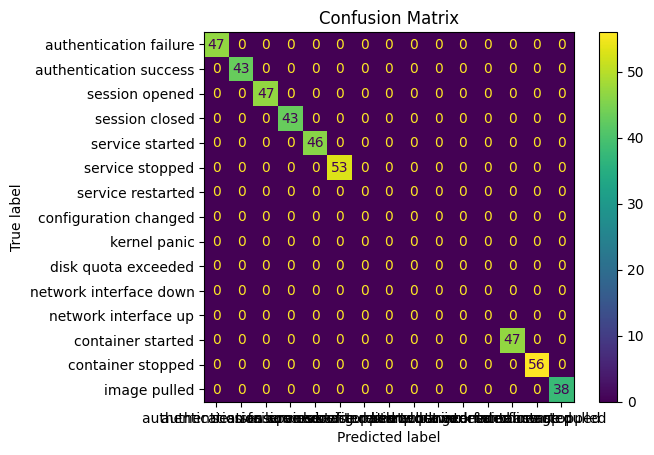

Classification Report:
                         precision    recall  f1-score   support

authentication failure       1.00      1.00      1.00        47
authentication success       1.00      1.00      1.00        43
        session opened       1.00      1.00      1.00        47
        session closed       1.00      1.00      1.00        43
       service started       1.00      1.00      1.00        46
       service stopped       1.00      1.00      1.00        53
     service restarted       0.00      0.00      0.00         0
 configuration changed       0.00      0.00      0.00         0
          kernel panic       0.00      0.00      0.00         0
   disk quota exceeded       0.00      0.00      0.00         0
network interface down       0.00      0.00      0.00         0
  network interface up       0.00      0.00      0.00         0
     container started       1.00      1.00      1.00        47
     container stopped       1.00      1.00      1.00        56
          image

In [113]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

# Get predictions from the model
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Ensure the true labels are also integers
true_labels = (
    test_labels.values
)  # Convert the pandas Series to a numpy array if necessary

# Define the full list of labels (indices) and the corresponding label names
label_indices = list(range(len(labels)))
label_names = list(labels.keys())

# Generate confusion matrix with full label set
cm = confusion_matrix(true_labels, preds, labels=label_indices)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

# Plot confusion matrix
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Generate classification report with full label set
report = classification_report(
    true_labels, preds, labels=label_indices, target_names=label_names, zero_division=0
)
print("Classification Report:\n", report)

# Extract loss values from log history
training_loss = [
    entry["loss"]
    for entry in trainer.state.log_history
    if "loss" in entry and "eval_loss" not in entry
]
training_steps = [
    entry["step"]
    for entry in trainer.state.log_history
    if "loss" in entry and "eval_loss" not in entry
]
eval_loss = [
    entry["eval_loss"] for entry in trainer.state.log_history if "eval_loss" in entry
]
eval_steps = [
    entry["step"] for entry in trainer.state.log_history if "eval_loss" in entry
]

# Align lengths of training and evaluation steps/losses
if len(training_steps) > len(eval_steps):
    training_steps = training_steps[: len(eval_steps)]
    training_loss = training_loss[: len(eval_loss)]
elif len(eval_steps) > len(training_steps):
    eval_steps = eval_steps[: len(training_steps)]
    eval_loss = eval_loss[: len(training_loss)]

# Plot training & evaluation loss
# plt.figure(figsize=(12, 6))
# plt.plot(training_steps, training_loss, label="Training Loss")
# plt.plot(eval_steps, eval_loss, label="Evaluation Loss")
# plt.xlabel("Steps")
# plt.ylabel("Loss")
# plt.title("Training and Evaluation Loss")
# plt.legend()
# plt.show()

## Step 11: Load and Explore the Insights Data
First, let's load the insights data from the provided CSV file and explore its structure.

In [114]:
# Load the insights data
insights_file_path = "insights_rules.csv"
insights = pd.read_csv(insights_file_path)

# Display the first few rows of the insights data
print(insights.head())

  rule_id           created_at           updated_at  category_id  \
0  rule_0  2024-06-11T00:00:00  2024-06-26T00:00:00            2   
1  rule_1  2024-06-27T00:00:00  2024-06-28T00:00:00            1   
2  rule_2  2024-06-02T00:00:00  2024-06-27T00:00:00            1   
3  rule_3  2024-06-17T00:00:00  2024-06-21T00:00:00            4   
4  rule_4  2024-06-02T00:00:00  2024-06-12T00:00:00            4   

  category_name         impact_name  impact  likelihood  node_id  \
0      Security  Decreased Security       2           4  9694070   
1  Availability       Best Practice       1           2  6754986   
2  Availability       Best Practice       1           3  3660212   
3   Performance  Decreased Security       2           3  3519521   
4   Performance       Best Practice       1           3  8828181   

           tags  playbook_count  reboot_required         publish_date  \
0      database               1             True  2024-06-29T00:00:00   
1        tuning               1     

## Step 12: Preprocess the Insights Data
Assume that the insights data has similar columns as the logs (e.g., timestamp, insight message). Preprocess the insights data to align with the logs.

In [115]:
import re

# Preprocess insights
def preprocess_insight(insight):
    insight = re.sub(
        r"\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}", "", insight
    )  # Remove timestamps
    insight = re.sub(r"[^\w\s]", "", insight)  # Remove punctuation
    insight = insight.lower()  # Convert to lowercase
    return insight


# Extract relevant columns and create a processed message column
insights["processed_message"] = insights.apply(
    lambda row: preprocess_insight(
        f"{row['category_name']} {row['impact_name']} {row['tags']}"
    ),
    axis=1,
)

# Ensure insights are correctly labeled before combining
insights["label"] = "insight"

# Display the first few rows of the processed insights
print("Processed Insights Data:")
print(insights[["rule_id", "processed_message", "label"]].head())

Processed Insights Data:
  rule_id                           processed_message    label
0  rule_0        security decreased security database  insight
1  rule_1           availability best practice tuning  insight
2  rule_2        availability best practice hardening  insight
3  rule_3  performance decreased security performance  insight
4  rule_4      performance best practice availability  insight


In [116]:
# Assuming logs dataframe is already loaded and preprocessed

# Display the first few rows of the logs data
print("Logs Data:")
print(logs.head())

# Ensure logs have correct labels (use integer labels directly if already correctly labeled)
print("Unique labels in logs dataset before mapping:", logs["label"].unique())

Logs Data:
                                                 log  \
0  Jun 01 14:04:04 docker(pam_unix)[4144]: sessio...   
1  Jun 01 11:23:16 sshd(pam_unix)[9190]: service ...   
2  Jun 01 15:29:18 docker(pam_unix)[5989]: servic...   
3  Jun 01 23:07:55 systemd(pam_unix)[8907]: image...   
4  Jun 01 00:03:38 docker(pam_unix)[5518]: sessio...   

                                       processed_log  label  
0  jun 01 140404 dockerpam_unix4144 session close...      3  
1  jun 01 112316 sshdpam_unix9190 service started...      4  
2  jun 01 152918 dockerpam_unix5989 service start...      4  
3  jun 01 230755 systemdpam_unix8907 image pulled...     14  
4  jun 01 000338 dockerpam_unix5518 session opene...      2  
Unique labels in logs dataset before mapping: [ 3  4 14  2 12  0  5  1 13]


## Step 13: Combine Logs and Insights Data

Combine the log data and the insights data into a single dataset for training.

In [117]:
# Ensure insights are correctly labeled before combining
insights["label"] = "insight"

# Create a unified dataset with logs and insights
logs["source"] = "log"
insights["source"] = "insight"

# Rename columns for consistency
logs = logs.rename(columns={"log": "message", "processed_log": "processed_message"})
insights = insights.rename(
    columns={"rule_id": "id", "processed_message": "processed_message"}
)

# Combine the datasets
combined_data = pd.concat(
    [
        logs[["message", "processed_message", "label", "source"]],
        insights[["processed_message", "label", "source"]],
    ],
    ignore_index=True,
)

# Display the first few rows of the combined dataset
print("Combined Data:")
print(combined_data.head())

# Display unique labels in the combined dataset before mapping
print(
    "Unique labels in combined dataset before mapping:", combined_data["label"].unique()
)

Combined Data:
                                             message  \
0  Jun 01 14:04:04 docker(pam_unix)[4144]: sessio...   
1  Jun 01 11:23:16 sshd(pam_unix)[9190]: service ...   
2  Jun 01 15:29:18 docker(pam_unix)[5989]: servic...   
3  Jun 01 23:07:55 systemd(pam_unix)[8907]: image...   
4  Jun 01 00:03:38 docker(pam_unix)[5518]: sessio...   

                                   processed_message label source  
0  jun 01 140404 dockerpam_unix4144 session close...     3    log  
1  jun 01 112316 sshdpam_unix9190 service started...     4    log  
2  jun 01 152918 dockerpam_unix5989 service start...     4    log  
3  jun 01 230755 systemdpam_unix8907 image pulled...    14    log  
4  jun 01 000338 dockerpam_unix5518 session opene...     2    log  
Unique labels in combined dataset before mapping: [3 4 14 2 12 0 5 1 13 'insight']


In [118]:
# Create a mapping for 'insight' label only
label_mapping = {"insight": 15}

# Apply the label mapping to the combined dataset
combined_data["label"] = combined_data["label"].replace(label_mapping)

# Ensure labels are integers
combined_data["label"] = combined_data["label"].astype(int)

# Display the first few rows of the combined dataset to verify the label conversion
print("Combined Data After Mapping:")
print(combined_data.head())

# Display unique labels in the combined dataset after mapping
print(
    "Unique labels in combined dataset after mapping:", combined_data["label"].unique()
)

Combined Data After Mapping:
                                             message  \
0  Jun 01 14:04:04 docker(pam_unix)[4144]: sessio...   
1  Jun 01 11:23:16 sshd(pam_unix)[9190]: service ...   
2  Jun 01 15:29:18 docker(pam_unix)[5989]: servic...   
3  Jun 01 23:07:55 systemd(pam_unix)[8907]: image...   
4  Jun 01 00:03:38 docker(pam_unix)[5518]: sessio...   

                                   processed_message  label source  
0  jun 01 140404 dockerpam_unix4144 session close...      3    log  
1  jun 01 112316 sshdpam_unix9190 service started...      4    log  
2  jun 01 152918 dockerpam_unix5989 service start...      4    log  
3  jun 01 230755 systemdpam_unix8907 image pulled...     14    log  
4  jun 01 000338 dockerpam_unix5518 session opene...      2    log  
Unique labels in combined dataset after mapping: [ 3  4 14  2 12  0  5  1 13 15]


/var/folders/8r/2hn86n416n58v77nhrr2_mhw0000gn/T/ipykernel_16893/3580182334.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_data["label"] = combined_data["label"].replace(label_mapping)


## Step 14: Tokenize the Combined Dataset

In [119]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

# Tokenize the combined dataset
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
combined_encodings = tokenizer(
    combined_data["processed_message"].tolist(), truncation=True, padding=True
)

# Split the combined data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    combined_data["processed_message"],
    combined_data["label"],
    test_size=0.2,
    random_state=42,
)

# Tokenize the training and test sets
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

# Verify tokenization
print("First 5 tokenized train texts:")
print(train_encodings["input_ids"][:5])

First 5 tokenized train texts:
[[101, 2836, 7809, 2836, 3279, 9211, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 11343, 10548, 3036, 2836, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 12022, 2654, 6185, 28311, 10790, 2291, 18927, 3286, 1035, 19998, 19317, 23499, 2326, 2318, 8833, 18442, 21318, 2094, 25746, 2509, 7327, 3593, 2683, 10790, 23746, 2100, 26307, 2099, 1054, 15006, 2102, 16147, 17465, 2575, 2620, 21926, 2620, 12521, 2487, 5310, 20330, 19841, 102, 0, 0, 0, 0, 0], [101, 3036, 10548, 3036, 9211, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 3036, 2190, 3218, 15899, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


## Step 15: Create Dataset Objects

In [120]:
import torch

class CombinedDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.reset_index(drop=True).astype(int)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item


train_dataset = CombinedDataset(train_encodings, train_labels)
test_dataset = CombinedDataset(test_encodings, test_labels)

# Verify dataset objects
print("First item in train dataset:", train_dataset[0])

First item in train dataset: {'input_ids': tensor([ 101, 2836, 7809, 2836, 3279, 9211,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0]), 'labels': tensor(15)}


## Step 16: Train the Model

In [121]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import numpy as np

# Set device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

# Load pre-trained BERT model with a classification head
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=16
).to(device)


model.to(device)

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",  # output directory
    num_train_epochs=3,  # number of training epochs
    per_device_train_batch_size=8,  # batch size for training
    per_device_eval_batch_size=8,  # batch size for evaluation
    warmup_steps=500,  # number of warmup steps for learning rate scheduler
    weight_decay=0.01,  # strength of weight decay
    logging_dir="./logs",  # directory for storing logs
    logging_steps=10,
    no_cuda=True,
    gradient_accumulation_steps=2,  # Gradient accumulation
)


# Define a function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = np.sum(preds == labels) / len(labels)
    return {"accuracy": accuracy}


# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/gsampaio/redhat/ai/bert-linux-logs/.venv/lib/python3.11/site-packages/transformers/training_args.py:1509: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [122]:
# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()

# Save the model
model.save_pretrained("./fine-tuned-bert-insights")
tokenizer.save_pretrained("./fine-tuned-bert-insights")

print("Evaluation Results:", eval_results)

  0%|          | 0/465 [00:00<?, ?it/s]

{'loss': 2.6912, 'grad_norm': 7.3516130447387695, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.06}
{'loss': 2.6767, 'grad_norm': 7.971421241760254, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.13}
{'loss': 2.5413, 'grad_norm': 8.560558319091797, 'learning_rate': 3e-06, 'epoch': 0.19}
{'loss': 2.5229, 'grad_norm': 14.195094108581543, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.26}
{'loss': 2.4295, 'grad_norm': 10.73659610748291, 'learning_rate': 5e-06, 'epoch': 0.32}
{'loss': 2.4293, 'grad_norm': 8.786853790283203, 'learning_rate': 6e-06, 'epoch': 0.39}
{'loss': 2.319, 'grad_norm': 9.837419509887695, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.45}
{'loss': 2.1893, 'grad_norm': 9.364843368530273, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.52}
{'loss': 2.041, 'grad_norm': 9.377402305603027, 'learning_rate': 9e-06, 'epoch': 0.58}
{'loss': 1.7996, 'grad_norm': 8.473133087158203, 'learning_rate': 1e-05, 'epoch': 0.65}
{'loss': 1.7523, 'grad_norm': 6.452667

  0%|          | 0/78 [00:00<?, ?it/s]

Evaluation Results: {'eval_loss': 0.003924312070012093, 'eval_accuracy': 1.0, 'eval_runtime': 9.2815, 'eval_samples_per_second': 66.799, 'eval_steps_per_second': 8.404, 'epoch': 3.0}


  0%|          | 0/78 [00:00<?, ?it/s]

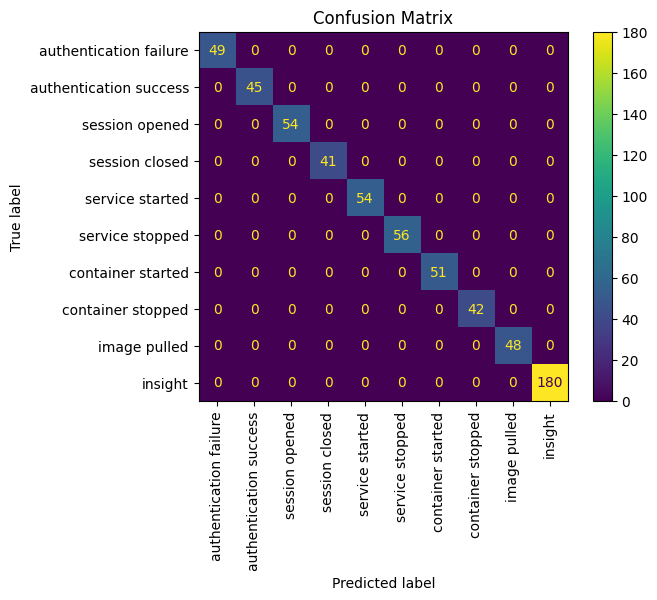

In [136]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Define the classification labels including 'insight'
labels = {
    "authentication failure": 0,
    "authentication success": 1,
    "session opened": 2,
    "session closed": 3,
    "service started": 4,
    "service stopped": 5,
    "service restarted": 6,
    "configuration changed": 7,
    "kernel panic": 8,
    "disk quota exceeded": 9,
    "network interface down": 10,
    "network interface up": 11,
    "container started": 12,
    "container stopped": 13,
    "image pulled": 14,
    "insight": 15,
}

# Get predictions on the test set
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_labels, preds)
unique_labels = np.unique(test_labels)

# Reverse mapping from indices to label names
reverse_label_mapping = {v: k for k, v in labels.items()}

# Generate the label names list
label_names = [reverse_label_mapping[label] for label in unique_labels]

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.show()

/var/folders/8r/2hn86n416n58v77nhrr2_mhw0000gn/T/ipykernel_16893/682248696.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "timestamp": pd.date_range(start="2024-01-01", periods=100, freq="H"),


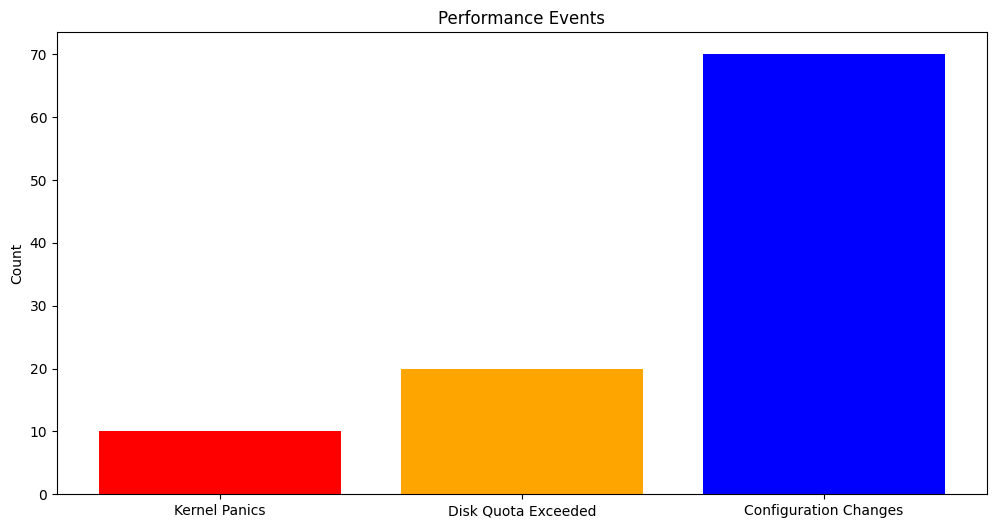

In [145]:
# Synthetic log data for performance events
performance_logs = pd.DataFrame(
    {
        "timestamp": pd.date_range(start="2024-01-01", periods=100, freq="H"),
        "event": np.random.choice(
            ["kernel panic", "disk quota exceeded", "configuration changed"],
            size=100,
            p=[0.1, 0.2, 0.7],
        ),
        "component": np.random.choice(
            ["component1", "component2", "component3"], size=100
        ),
    }
)

# Calculate performance metrics
kernel_panics = performance_logs[performance_logs["event"] == "kernel panic"].shape[0]
disk_quotas_exceeded = performance_logs[
    performance_logs["event"] == "disk quota exceeded"
].shape[0]
config_changes = performance_logs[
    performance_logs["event"] == "configuration changed"
].shape[0]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(
    ["Kernel Panics", "Disk Quota Exceeded", "Configuration Changes"],
    [kernel_panics, disk_quotas_exceeded, config_changes],
    color=["red", "orange", "blue"],
)
plt.title("Performance Events")
plt.ylabel("Count")
plt.show()

/var/folders/8r/2hn86n416n58v77nhrr2_mhw0000gn/T/ipykernel_16893/572922657.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "timestamp": pd.date_range(start="2024-01-01", periods=100, freq="H"),


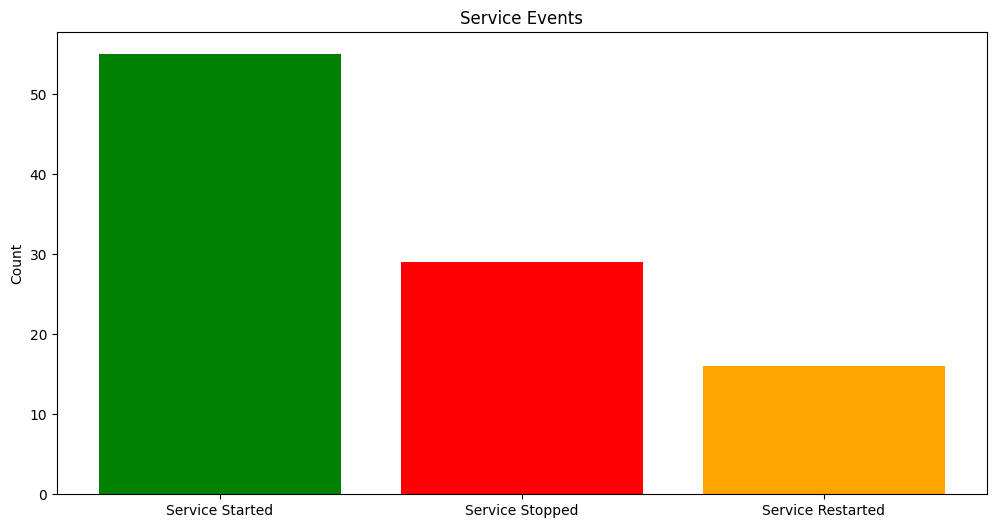

In [141]:
# Synthetic log data for service events
service_logs = pd.DataFrame(
    {
        "timestamp": pd.date_range(start="2024-01-01", periods=100, freq="H"),
        "event": np.random.choice(
            ["service started", "service stopped", "service restarted"],
            size=100,
            p=[0.5, 0.3, 0.2],
        ),
        "service": np.random.choice(["service1", "service2", "service3"], size=100),
    }
)

# Calculate service health metrics
start_events = service_logs[service_logs["event"] == "service started"].shape[0]
stop_events = service_logs[service_logs["event"] == "service stopped"].shape[0]
restart_events = service_logs[service_logs["event"] == "service restarted"].shape[0]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(
    ["Service Started", "Service Stopped", "Service Restarted"],
    [start_events, stop_events, restart_events],
    color=["green", "red", "orange"],
)
plt.title("Service Events")
plt.ylabel("Count")
plt.show()

/var/folders/8r/2hn86n416n58v77nhrr2_mhw0000gn/T/ipykernel_16893/580523466.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "timestamp": pd.date_range(start="2024-01-01", periods=100, freq="H"),


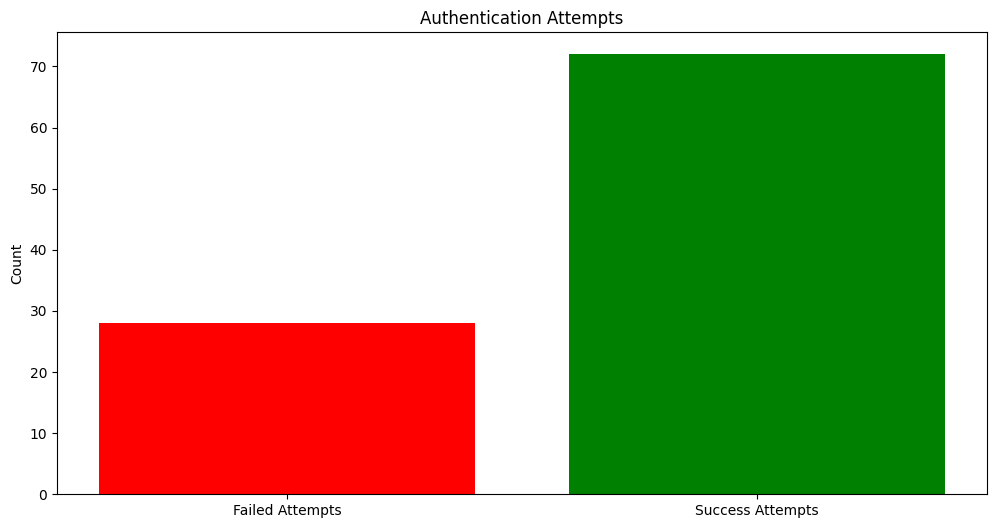

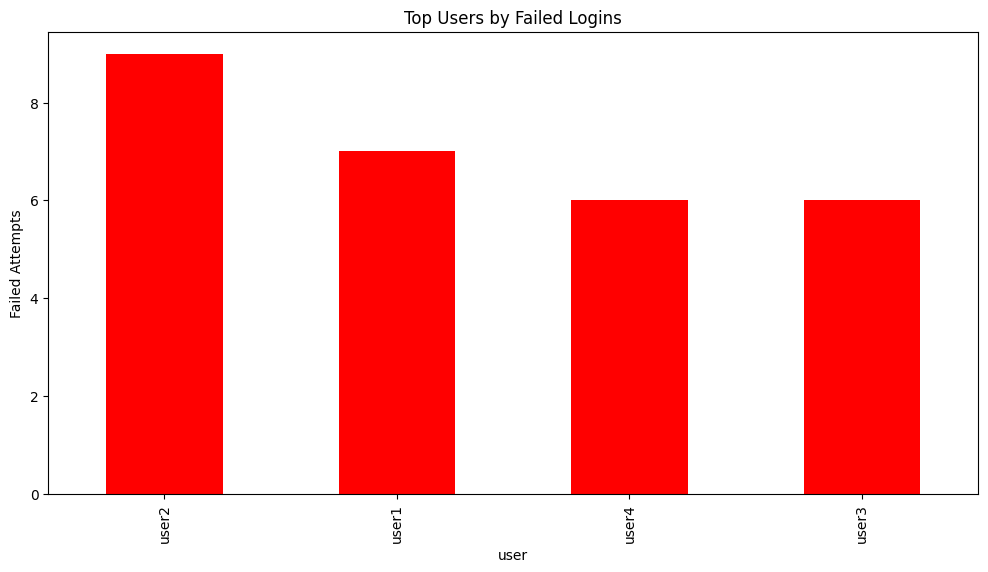

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Synthetic log data for authentication events
auth_logs = pd.DataFrame(
    {
        "timestamp": pd.date_range(start="2024-01-01", periods=100, freq="H"),
        "event": np.random.choice(
            ["authentication failure", "authentication success"], size=100, p=[0.3, 0.7]
        ),
        "user": np.random.choice(["user1", "user2", "user3", "user4"], size=100),
    }
)

# Calculate authentication metrics
total_attempts = auth_logs.shape[0]
failed_attempts = auth_logs[auth_logs["event"] == "authentication failure"].shape[0]
success_attempts = auth_logs[auth_logs["event"] == "authentication success"].shape[0]
failure_rate = (failed_attempts / total_attempts) * 100

top_failed_users = (
    auth_logs[auth_logs["event"] == "authentication failure"]["user"]
    .value_counts()
    .head()
)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(
    ["Failed Attempts", "Success Attempts"],
    [failed_attempts, success_attempts],
    color=["red", "green"],
)
plt.title("Authentication Attempts")
plt.ylabel("Count")
plt.show()

top_failed_users.plot(kind="bar", color="red", figsize=(12, 6))
plt.title("Top Users by Failed Logins")
plt.ylabel("Failed Attempts")
plt.show()

/var/folders/8r/2hn86n416n58v77nhrr2_mhw0000gn/T/ipykernel_16893/1080349579.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "timestamp": pd.date_range(start="2024-01-01", periods=100, freq="H"),


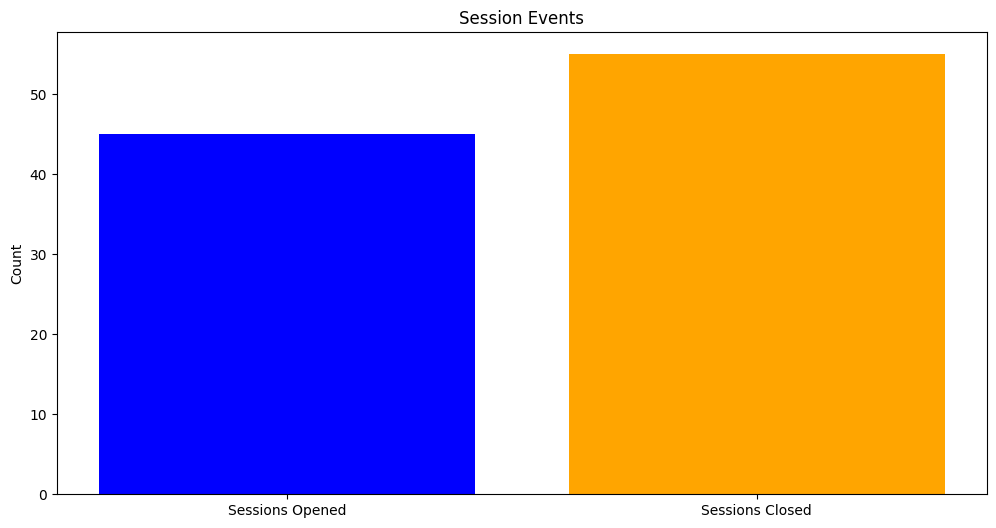

In [143]:
# Synthetic log data for session events
session_logs = pd.DataFrame(
    {
        "timestamp": pd.date_range(start="2024-01-01", periods=100, freq="H"),
        "event": np.random.choice(
            ["session opened", "session closed"], size=100, p=[0.5, 0.5]
        ),
        "session_id": np.random.randint(1, 50, size=100),
    }
)

# Calculate session metrics
opened_sessions = session_logs[session_logs["event"] == "session opened"].shape[0]
closed_sessions = session_logs[session_logs["event"] == "session closed"].shape[0]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(
    ["Sessions Opened", "Sessions Closed"],
    [opened_sessions, closed_sessions],
    color=["blue", "orange"],
)
plt.title("Session Events")
plt.ylabel("Count")
plt.show()

/var/folders/8r/2hn86n416n58v77nhrr2_mhw0000gn/T/ipykernel_16893/2903166241.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "timestamp": pd.date_range(start="2024-01-01", periods=100, freq="H"),


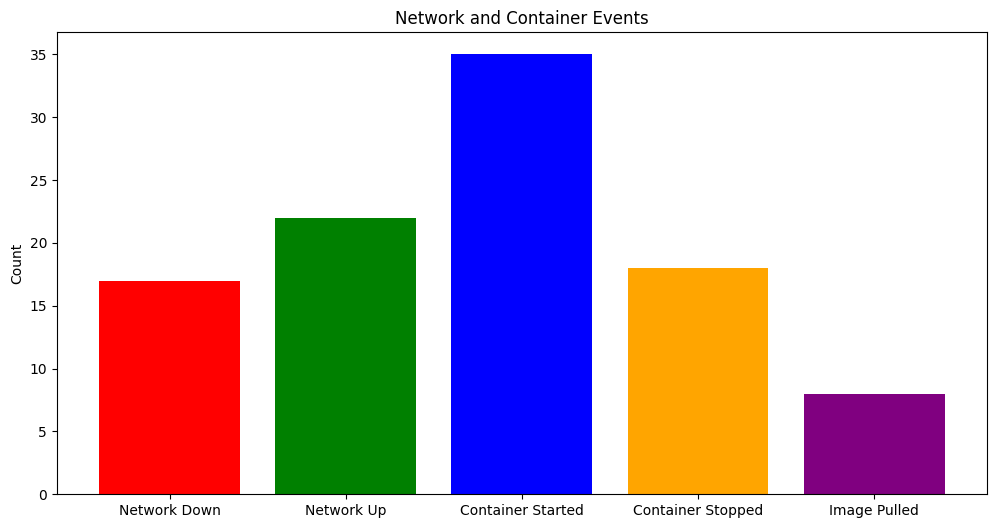

In [146]:
# Synthetic log data for network and container events
network_container_logs = pd.DataFrame(
    {
        "timestamp": pd.date_range(start="2024-01-01", periods=100, freq="H"),
        "event": np.random.choice(
            [
                "network interface down",
                "network interface up",
                "container started",
                "container stopped",
                "image pulled",
            ],
            size=100,
            p=[0.2, 0.2, 0.3, 0.2, 0.1],
        ),
        "entity": np.random.choice(
            ["network1", "network2", "container1", "container2"], size=100
        ),
    }
)

# Calculate network and container metrics
network_down_events = network_container_logs[
    network_container_logs["event"] == "network interface down"
].shape[0]
network_up_events = network_container_logs[
    network_container_logs["event"] == "network interface up"
].shape[0]
container_started_events = network_container_logs[
    network_container_logs["event"] == "container started"
].shape[0]
container_stopped_events = network_container_logs[
    network_container_logs["event"] == "container stopped"
].shape[0]
image_pulled_events = network_container_logs[
    network_container_logs["event"] == "image pulled"
].shape[0]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(
    [
        "Network Down",
        "Network Up",
        "Container Started",
        "Container Stopped",
        "Image Pulled",
    ],
    [
        network_down_events,
        network_up_events,
        container_started_events,
        container_stopped_events,
        image_pulled_events,
    ],
    color=["red", "green", "blue", "orange", "purple"],
)
plt.title("Network and Container Events")
plt.ylabel("Count")
plt.show()